In [1]:
import pandas as pd
import numpy as np

import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

import keras_metrics

import cv2

import torch 
import torch.nn as nn
import torch.optim as optim

In [112]:
input_size = (32, 32)

def preprocess_dataset(image):
    image = cv2.resize(image, input_size)
    return image

In [113]:
# walk the directory containing alpaca/not alpaca and read them in. 
# might be different shapes
# all have 3 channels
alpaca_images = []
for dirname, _, filenames in os.walk('dataset/alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            alpaca_images.append(imnp)

not_alpaca_images = []
for dirname, _, filenames in os.walk('dataset/not alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            not_alpaca_images.append(imnp)

This is 1 channel, so we omit it (683, 1024) 4b9ef3ce2685ee32.jpg
This is 1 channel, so we omit it (914, 1024) 5a71db307230880e.jpg


## Preprocessing data

In [114]:
# scale image from [0, 255] to [0, 1]
alpaca_images = np.asarray(alpaca_images) / 255.
not_alpaca_images = np.asarray(not_alpaca_images) / 255.

# loading data
X = np.concatenate((alpaca_images, not_alpaca_images), axis=0) # X.shape=(325, 300, 300, 3)

# 0 -> alpaca_images, 1-> not_alpaca_images
y = keras.utils.to_categorical(np.concatenate((np.zeros(alpaca_images.shape[0], dtype=int),  # y.shape=(325,)
                    np.ones(not_alpaca_images.shape[0], dtype=int)), 
                   axis=0))


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(262, 32, 32, 3) (262, 2)
(30, 32, 32, 3) (30, 2)
(33, 32, 32, 3) (33, 2)


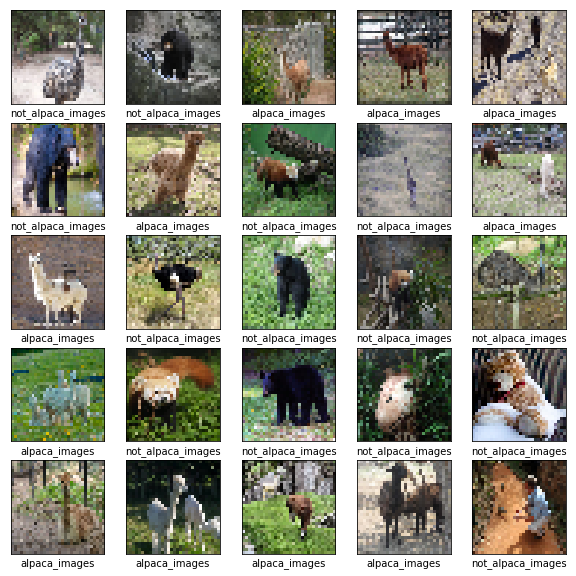

In [116]:
class_names = ['alpaca_images', 'not_alpaca_images']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[int(np.argmax(y_train[i]))])
plt.show()

## Traditional Conv2DModel Keras

In [117]:
cnn2d = keras.Sequential((
    # input layer
    keras.Input(shape=(32, 32, 3)),
    # convolutional layer1 + ActivationLayer1
    layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer1
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer2 + ActivationLayer2
    layers.Conv2D(filters=12, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer2
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer3 + ActivationLayer33
    layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # Dense layer1
    layers.Flatten(name='flatten'),
    layers.Dense(12),
    
    # output layer
    layers.Dense(2, activation='softmax'),
))

In [118]:
cnn2d.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 average_pooling2d_6 (Averag  (None, 15, 15, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 12)        1740      
                                                                 
 average_pooling2d_7 (Averag  (None, 6, 6, 12)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 8)           872       
                                                                 
 flatten (Flatten)           (None, 128)              

### Train Conv2DModel Keras

In [119]:
batch_size = 20
epochs = 3

cnn2d.compile(loss="categorical_crossentropy", 
              optimizer="sgd",
              metrics=[
                       #"accuracy", 
                       tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Precision(thresholds=0.5),
                       tf.keras.metrics.Recall(thresholds=0.5)
                      ])


cnn2d.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
          validation_data = (X_val, y_val)
#           validation_split=0.1
         )

cnn2d.save("models/keras_2dcnn.saved_model")

Epoch 1/3
14/14 [==============================] - 1s 60ms/step - loss: 0.6981 - categorical_accuracy: 0.5115 - precision_8: 0.5115 - recall_8: 0.5115 - val_loss: 0.7004 - val_categorical_accuracy: 0.4333 - val_precision_8: 0.4333 - val_recall_8: 0.4333
Epoch 2/3
14/14 [==============================] - 0s 19ms/step - loss: 0.6914 - categorical_accuracy: 0.5115 - precision_8: 0.5115 - recall_8: 0.5115 - val_loss: 0.6980 - val_categorical_accuracy: 0.4667 - val_precision_8: 0.4667 - val_recall_8: 0.4667
Epoch 3/3
14/14 [==============================] - 0s 20ms/step - loss: 0.6902 - categorical_accuracy: 0.5000 - precision_8: 0.5000 - recall_8: 0.5000 - val_loss: 0.6968 - val_categorical_accuracy: 0.5667 - val_precision_8: 0.5667 - val_recall_8: 0.5667


INFO:tensorflow:Assets written to: models/keras_2dcnn.saved_model/assets


INFO:tensorflow:Assets written to: models/keras_2dcnn.saved_model/assets


### Evaluate Conv2DModel Keras

In [120]:
cnn2d.evaluate(
    x=X_test,
    y=y_test)

2/2 [==============================] - 0s 83ms/step - loss: 0.6844 - categorical_accuracy: 0.6061 - precision_8: 0.6061 - recall_8: 0.6061


[0.6843746900558472,
 0.6060606241226196,
 0.6060606241226196,
 0.6060606241226196]

# Pytorch

In [121]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 20 

# Create data loaders for our datasets; shuffle for training, not for validation
train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float),
                          torch.tensor(y_train, dtype=torch.float))
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True) 

val_set = TensorDataset(torch.tensor(X_val, dtype=torch.float),
                        torch.tensor(y_val, dtype=torch.float))
val_dataloader = DataLoader(val_set)

test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float),
                         torch.tensor(y_test, dtype=torch.float))
test_dataloader = DataLoader(test_set)

# Traditional Conv2D approach Pytorch

In [122]:
class Conv2DModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features_after_flatten = 128
        
        # Block 1
        self.proposedLayer1 = nn.Conv2d(3, 16, 3)
        self.relu1 = nn.ReLU() # activation layer 1
        self.pool1 = nn.AvgPool2d(2)
        
        # Block 2
        self.proposedLayer2 = nn.Conv2d(16, 12, 3)
        self.relu2 = nn.ReLU() # activation layer 1
        self.pool2 = nn.AvgPool2d(2)
        
        # Block 3
        self.proposedLayer3 = nn.Conv2d(12, 8, 3)
        self.relu3 = nn.ReLU() # activation layer 1
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.n_features_after_flatten, 12)
        self.dense = nn.Linear(12, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        ## torch expected input format = (N, C, H, W)
        ## torch output format follows the same
        
        # Block 1
        x = self.proposedLayer1(x) ##(N, H, W, C)
        x = self.relu1(x)
        x = self.pool1(x)
        
#         # Block 2
        x = self.proposedLayer2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
#         # Block 3
        x = self.proposedLayer3(x)
        x = self.relu3(x)
        x = self.flatten(x).to(torch.float32)
        x = self.fc(x).float()
        x = self.dense(x)
        x = self.output(x)
        
        return x

### Train Conv2D Model

In [123]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    dataloader_tqdm = tqdm(train_dataloader)
    for i, data in enumerate(dataloader_tqdm):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(torch.permute(inputs, (0, 3, 1, 2)))#.squeeze(1)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
#             print('  batch {} loss: {}'.format(i + 1, last_loss))
            dataloader_tqdm.set_postfix_str('  batch {} loss: {}'.format(i + 1, last_loss))
            sleep(0.01)
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [127]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from time import sleep

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
lr = 0.001
EPOCHS = 5

writer = SummaryWriter('runs/{}_{}_{}_SGD'.format(lr, batch_size, EPOCHS))
epoch_number = 0
criterion = nn.CrossEntropyLoss()

model = Conv2DModel().float()
optimizer = optim.SGD(model.parameters(), lr=lr)


best_vloss = 1_000_000.

# EPOCHS_tqdm = tqdm(np.arange(EPOCHS))

for epoch in range(EPOCHS):
#     EPOCHS_tqdm.set_description('EPOCH {}:'.format(epoch_number + 1))
    print(('EPOCH {}:'.format(epoch_number + 1)))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(val_dataloader):
        vinputs, vlabels = vdata
        voutputs = model(torch.permute(vinputs, (0, 3, 1, 2)))#.squeeze(1)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
#     EPOCHS_tqdm.set_postfix_str('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
#     EPOCHS_tqdm.refresh() # to show immediately the update
#     sleep(0.01)
#     print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/conv2dmodel_{}'.format(epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


100%|██████████| 14/14 [00:00<00:00, 118.86it/s]


LOSS train 0.0 valid 0.6932341456413269
EPOCH 2:


100%|██████████| 14/14 [00:00<00:00, 167.17it/s]


LOSS train 0.0 valid 0.6932371854782104
EPOCH 3:


100%|██████████| 14/14 [00:00<00:00, 170.18it/s]


LOSS train 0.0 valid 0.6932403445243835
EPOCH 4:


100%|██████████| 14/14 [00:00<00:00, 171.75it/s]


LOSS train 0.0 valid 0.6932432055473328
EPOCH 5:


100%|██████████| 14/14 [00:00<00:00, 173.09it/s]


LOSS train 0.0 valid 0.6932469606399536


## Proposed Layer

In [132]:
class ProposedLayer(nn.Module):
    
    def __init__(self, num_filters, rf=3, stride=1):
        super().__init__()
        self.rf = rf
        self.num_filters = num_filters
        self.stride = stride
        
    def __len__(self, x):
        return len(x)
      
    def forward(self, X):
        self.batch = len(X[:,0])
        self.height = len([1] * X.shape[1])
        self.width = len([1] * X.shape[2])
        self.channel = len([1] * X.shape[3])
        
        self.featureMaps = []
        
        for n in range(self.num_filters):
            self.weightMatrix = torch.tensor(np.random.rand(self.height, self.width, self.channel))
            self.featureMaps.append(self.weightMatrix)
            
        self.featureMaps = torch.stack(self.featureMaps, dim=0)
        output = torch.tensor(np.empty((self.batch, self.height-self.rf+1, self.width-self.rf+1, self.num_filters)))
        
        for row in range(self.height - self.rf + 1):
            for col in range(self.width - self.rf + 1):
                for j,_ in enumerate(self.featureMaps):
                    for i,_ in enumerate(X):
                        receptive_field = self.featureMaps[j, row: row+self.rf, col: col+self.rf, :]
                        x_field = X[i, row: row+self.rf, col: col+self.rf, :]

                        x_field_ = torch.flatten(x_field)
                        receptive_field_ = torch.flatten(receptive_field)
                        output[i, row, col] = np.dot(x_field_, receptive_field_)                                
        
        return torch.permute(output, (0, 3, 1, 2))

### Input layer – ProposedLayer1– ActivationLayer1 – PoolingLayer1 – ProposedLayer2 – ActivationLayer2 – PoolingLayer2 – ProposedLayer3 – ActivationLayer3 – FullyConnectedLayer1/DenseLayer1 – OutputLayer/Softmax

In [143]:
class ProposedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features_after_flatten = 128
        
        # Block 1
        self.proposedLayer1 = ProposedLayer(num_filters=16, rf=3, stride=1) # proposed layer 1
        self.relu1 = nn.ReLU() # activation layer 1
        self.pool1 = nn.AvgPool2d(2)
        
        # Block 2
        self.proposedLayer2 = ProposedLayer(num_filters=12, rf=3, stride=1) # proposed layer 1
        self.relu2 = nn.ReLU() # activation layer 1
        self.pool2 = nn.AvgPool2d(2)
        
        # Block 3
        self.proposedLayer3 = ProposedLayer(num_filters=8, rf=3, stride=1) # proposed layer 1
        self.relu3 = nn.ReLU() # activation layer 1
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.n_features_after_flatten, 12)
        self.dense = nn.Linear(12, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        ## torch expected input format = (N, C, H, W)
        ## torch output format follows the same
        
        # Block 1
        x = self.proposedLayer1(x) ##(N, H, W, C)
        x = self.relu1(x)
        x = self.pool1(x)
        x = torch.permute(x, (0, 2, 3, 1)) ##(N, H, W, C)
        
        # Block 2
        x = self.proposedLayer2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.permute(x, (0, 2, 3, 1))
        
        # Block 3
        x = self.proposedLayer3(x)
        x = self.relu3(x)
        x = self.flatten(x).to(torch.float32)
        x = self.fc(x).float()
        x = self.dense(x)
        x = self.output(x)
        
        return x

In [145]:
model=ProposedModel()
x = torch.tensor(X_train, dtype=torch.float)
model(x[:3]).shape

torch.Size([3, 2])

## Train Proposed Model

In [148]:
def train_one_epoch_pm(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    dataloader_tqdm = tqdm(train_dataloader)
    for i, data in enumerate(dataloader_tqdm):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)#.squeeze(1)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
#             print('  batch {} loss: {}'.format(i + 1, last_loss))
            dataloader_tqdm.set_postfix_str('  batch {} loss: {}'.format(i + 1, last_loss))
            sleep(0.01)
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [151]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from time import sleep

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
lr = 0.001
EPOCHS = 5

writer = SummaryWriter('runs/{}_{}_{}_SGD'.format(lr, batch_size, EPOCHS))
epoch_number = 0
criterion = nn.CrossEntropyLoss()

model = ProposedModel().float()
optimizer = optim.SGD(model.parameters(), lr=lr)


best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print(('EPOCH {}:'.format(epoch_number + 1)))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch_pm(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(val_dataloader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)#.squeeze(1)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/proposedmodel_{}'.format(epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


100%|██████████| 14/14 [02:07<00:00,  9.11s/it]


LOSS train 0.0 valid 0.8132615685462952
EPOCH 2:


100%|██████████| 14/14 [31:01<00:00, 132.95s/it]


LOSS train 0.0 valid 0.8132615685462952
EPOCH 3:


100%|██████████| 14/14 [15:54<00:00, 68.20s/it]  


LOSS train 0.0 valid 0.8132615685462952
EPOCH 4:


100%|██████████| 14/14 [02:02<00:00,  8.76s/it]


LOSS train 0.0 valid 0.8132615685462952
EPOCH 5:


100%|██████████| 14/14 [02:03<00:00,  8.79s/it]


LOSS train 0.0 valid 0.8132615685462952


In [20]:
%load_ext tensorboard

In [ ]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('alpaca_images', img_grid)

In [89]:
images_loader, labels_loader = next(iter(train_dataloader))

# writer.add_graph(model, images_loader)
# writer.close()

torch.permute(images_loader, (0, 3, 1, 2)).shape

torch.Size([20, 3, 32, 32])

In [87]:
%tensorboard --logdir runs
